# Movies feature graph

In [44]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import ast

# Constants
ML_DATA_PATH = 'datasets/ml-100k-convert/'

%matplotlib inline

## Combining the tmdb and MovieLens dataset

In [45]:
# Load imdb datasets
tmdb_movies = pd.read_csv('datasets/tmdb_5000_movies.csv', delimiter=',') 
tmdb_movies_cast = pd.read_csv('datasets/tmdb_5000_credits.csv', delimiter=',') 

# Drop some columns and change index
tmdb_movies = tmdb_movies.drop(columns=["homepage", "status", "tagline", "overview", "original_title"])
tmdb_movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124


In [46]:
# Load MovieLens dataset
ML_links = pd.read_csv('datasets/ml-latest/links.csv', delimiter=',')
#ML_ratings = pd.read_csv('datasets/ml-latest-small/ratings.csv', delimiter=',') 
ML_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


We can only use the movies that are in the TMDB_5000, ml-latest and ml-100k datasets, 

In [47]:
# Load links of the movies to use
movie_links = pd.read_csv('datasets/ml_links.csv')
movie_links.head()

,ML-100k-convertId,ML-latestId
0,1,1
1,2,10
2,3,18
3,4,21
4,5,22


In [81]:
# Join ML_links and the total links
movies = ML_links.merge(movie_links, left_on="movieId", right_on="ML-latestId")
# Create a merge of the movies in tmdb 5000 and movielens
movies = tmdb_movies.merge(movies, left_on="id", right_on="tmdbId")
movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,movieId,imdbId,tmdbId,ML-100k-convertId,ML-latestId
0,200000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,100.025899,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-11-18,1845034188,194.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Titanic,7.5,7562,1721,120338,597.0,313,1721
1,175000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",9804,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 331, ""na...",en,44.640292,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-07-28,264218220,135.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Waterworld,5.9,992,208,114898,9804.0,554,208
2,125000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",415,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84...",en,50.073575,"[{""name"": ""PolyGram Filmed Entertainment"", ""id...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-06-20,238207122,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Batman & Robin,4.2,1418,1562,118688,415.0,254,1562
3,116000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",9619,"[{""id"": 720, ""name"": ""helicopter""}, {""id"": 141...",en,16.904440,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-02-07,178127760,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Dante's Peak,5.7,428,1438,118928,9619.0,323,1438
4,110000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",714,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,42.887121,"[{""name"": ""Eon Productions"", ""id"": 7576}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-12-11,333011068,119.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Tomorrow Never Dies,6.0,925,1722,120347,714.0,751,1722


In [82]:
# id is tmdbId and ML-latestId is movieId
# From now on use tmdbId as the real ID
movies.drop(columns=["tmdbId", "movieId"], inplace=True)
movies.to_csv("datasets/final_movies.csv", index=False)

In [57]:
movies.shape

(480, 18)

The combined dataset of the ML_latest, ML_100k and tmdb contains 480 movies

## Feature networks

There are many possible networds we could create from the features. 

We will make the following graphs:
* genres
* keywords
* revenue


### Genre network

Here, we use the item dataset of ml-100k-convert

In [33]:
genres = pd.read_csv(ML_DATA_PATH+'genre.tsv', sep='\t', names=['genre', 'id'])
genres = genres['genre'].tolist()

In [58]:
# ML_100k_movies already cleaned the genres, so we'll use that 
ML_100k_movies = pd.read_csv(ML_DATA_PATH + 'item.tsv', sep='\t', header=None, names=['id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genres)
ML_100k_movies = ML_100k_movies.drop(columns=['release_date', 'video_release_date', 'IMDb_URL'])
# Drop ones with unknown genre
#ML_100k_movies = ML_100k_movies[ML_100k_movies['unknown'] == 0].drop(columns=['unknown','id'])
#del genres[0]
ML_100k_movies.head()

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [61]:
# Use only movies from the final dataset
ML_100k_movies = ML_100k_movies[ML_100k_movies["id"].isin(movies["ML-100k-convertId"])]
ML_100k_movies.shape

(480, 21)

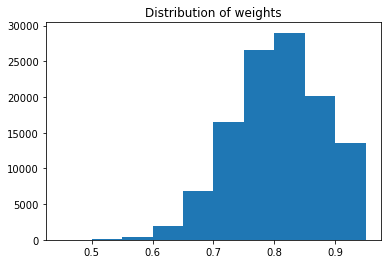

In [62]:
# 1 means completely similar
movie_distances = 1-pdist(ML_100k_movies.drop(columns='title'), 'hamming')
plt.hist(movie_distances)
plt.title('Distribution of weights')
plt.show()

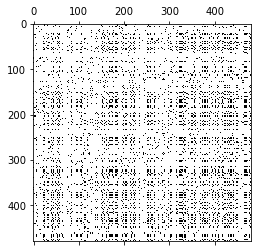

In [65]:
adjacency = squareform(np.where(movie_distances>0.85,1,0))
plt.spy(adjacency)
plt.show()

In [66]:
# Add labels for visualisation in Gephi
ML_100k_movies['label'] = ML_100k_movies.apply(lambda x: [genre for genre in genres if x[genre] != 0], axis=1)
ML_100k_movies['label'] = ML_100k_movies.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)

In [67]:
ML_100k_movies['label']

0               {0: 'Animation-Children's-Comedy'}
1                 {0: 'Action-Adventure-Thriller'}
2                                  {0: 'Thriller'}
3                       {0: 'Action-Comedy-Drama'}
4                      {0: 'Crime-Drama-Thriller'}
                           ...                    
1614    {0: 'Action-Adventure-Children's-Fantasy'}
1650                         {0: 'Drama-Thriller'}
1653                                 {0: 'Comedy'}
1663                                 {0: 'Comedy'}
1679                          {0: 'Drama-Romance'}
Name: label, Length: 480, dtype: object

In [68]:
graph = nx.from_numpy_array(adjacency)
nx.set_node_attributes(graph, ML_100k_movies['label'])
nx.write_gexf(graph, 'movie_genre_dense.gexf')

### Keywords network

Here, we have to combine 3 datasets: ml-latest-small (contains the tmdb id's), with ml-100k-convert (real used data) and tmdb (contains the keywords)

In [83]:
movie_keywords = movies[['id', 'title', 'keywords']]
movie_keywords

,id,title,keywords
0,597,Titanic,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298..."
1,9804,Waterworld,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 331, ""na..."
2,415,Batman & Robin,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84..."
3,9619,Dante's Peak,"[{""id"": 720, ""name"": ""helicopter""}, {""id"": 141..."
4,714,Tomorrow Never Dies,"[{""id"": 212, ""name"": ""london england""}, {""id"":..."
...,...,...,...
475,10218,Swingers,"[{""id"": 10183, ""name"": ""independent film""}, {""..."
476,9821,The Mighty,"[{""id"": 2494, ""name"": ""ohio""}, {""id"": 10683, ""..."
477,16388,The Brothers McMullen,"[{""id"": 9673, ""name"": ""love""}, {""id"": 10183, ""..."
478,2292,Clerks,"[{""id"": 1361, ""name"": ""salesclerk""}, {""id"": 30..."


In [84]:
keywords = movie_keywords['keywords']
# Convert string to dict
keywords = keywords.apply(lambda x: ast.literal_eval(x))
# Convert list of dicts list of keywords
keywords = keywords.apply(lambda x: [d['name'] for d in x ])
movie_keywords.loc[:, 'keywords'] = keywords
movie_keywords

C:\Users\Admin\Anaconda3\envs\ntds_2019\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,title,keywords
0,597,Titanic,"[shipwreck, iceberg, ship, panic, titanic, oce..."
1,9804,Waterworld,"[ocean, tattoo, mutant, water, dystopia, dooms..."
2,415,Batman & Robin,"[double life, dc comics, dual identity, crime ..."
3,9619,Dante's Peak,"[helicopter, small town, mayor, evacuation, mo..."
4,714,Tomorrow Never Dies,"[london england, england, spy, china, news bro..."
...,...,...,...
475,10218,Swingers,"[independent film, stuffed animal, hollywood, ..."
476,9821,The Mighty,"[ohio, coming of age, disabled, learning disab..."
477,16388,The Brothers McMullen,"[love, independent film, best friend, true lov..."
478,2292,Clerks,"[salesclerk, loser, aftercreditsstinger]"


In [85]:
movie_keywords = movie_keywords.drop(columns=['title','id'])
# Explode list of keywords to different rows
movie_keywords = movie_keywords.explode('keywords')
movie_keywords['count'] = 1
# Pivot so keywords become columns
movie_keywords = movie_keywords.pivot(columns='keywords', values='count').fillna(0)

In [86]:
distances = 1-pdist(movie_keywords,'jaccard')

In [87]:
squareform(distances)

array([[0.        , 0.        , 0.        , ..., 0.04347826, 0.        ,
        0.04347826],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04347826, 0.        , 0.        , ..., 0.        , 0.        ,
        0.25      ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04347826, 0.        , 0.        , ..., 0.25      , 0.        ,
        0.        ]])

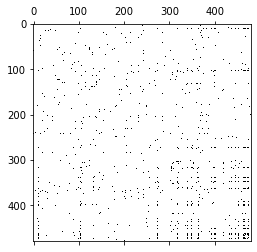

In [88]:
adjacency = squareform(np.where(distances>0.06,1,0))
plt.spy(adjacency)
plt.show()

In [89]:
graph = nx.from_numpy_array(adjacency)
nx.write_gexf(graph, 'movie_keywords.gexf')